In [2]:
import sys
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [3]:
def convolute(signal,filter,correlate=False):
    '''
    This function performs correlation of the signal with filter, if correlation = True
    Otherwise it performs convolution.
    '''
    n=signal.shape[0]
    m=filter.shape[0]
    if n==0:
        sys.exit('Exit from convolute: empty signal.')
    if m==0:
        sys.exit('Exit from convolute: empty filter.')
    if m>n:
        return None
    
    if correlate == False:
        filter=filter[::-1]
        iterations=n
        signal=np.hstack([signal,signal])
    else:
        iterations=n-m+1
    
    result=np.zeros(iterations)
    for i in range(iterations):
        result[i]=np.sum(signal[i:i+m]*filter)
    return result

In [4]:
def getHaar(length):
    '''
    Creates a Haar filter
    '''
    if length%2==0:
        magnitude=1/np.sqrt(length)
        haar=np.ones(length)
        haar[::2]=-1
        haar *= magnitude
    else:
        sys.exit('Exit from getHaar: can not create Haar series with odd length '+str(length))
    return haar

In [5]:
def getFilters():
    '''
    Create a Haar and a scalar filter.
    '''
    haar=getHaar(2)
    scalar=np.copy(haar)
    scalar[::2] *= (-1)
    
    return haar,scalar[::-1]

In [27]:
def rowConvolve(img,filter):
    '''
    Correlate each row of an umage with a filter
    '''
    r=img.shape[0]
    for row in range(r):
        tempRow=convolute(img[row],filter,True)[::2]
        if row == 0:
            tempimg=tempRow[:]
        else:
            tempimg=np.vstack([tempimg,tempRow])
    return tempimg

In [28]:
def colConvolve(img,filter):
    '''
    Correlate each column of an umage with a filter
    '''
    c=img.shape[1]
    for col in range(c):
        temp=convolute(img[:,col],filter,True)[::2]
        temp=temp.reshape(temp.shape[0],1)
        if col == 0:
            tempimg=temp[:,:]
        else:
            tempimg=np.hstack([tempimg,temp])
    return tempimg

In [8]:
def convolveLevelImage2D(img,rowFilter,colFilter):
    '''
    Correlate a 2D image
    '''
    temp=rowConvolve(img,rowFilter)
    return colConvolve(temp,colFilter)

In [29]:
def getWavelets(img):
    '''
    Create four wavelets for an input image
    '''
    wfilter,sfilter=getFilters()    # wavelet filter as Haar function -1,+1

    ## HH wavelet
    HH=convolveLevelImage2D(img,wfilter,wfilter)
    ## HL wavelet
    HL=convolveLevelImage2D(img,wfilter,sfilter)
    ## LH wavelet
    LH=convolveLevelImage2D(img,sfilter,wfilter)
    ## LL wavelet
    LL=convolveLevelImage2D(img,sfilter,sfilter)
    
    return np.dstack([LL,LH,HL,HH])

In [34]:
def showResults(img,oimg,rimg):
    '''
    Plot original, wavelets and reconstructed images.
    '''
    plt.clf()
    
    plt.subplot(131)
    plt.imshow(img,cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(oimg,cmap='gray')
    plt.title('Wavelets')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(rimg,cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
    
    plt.savefig('wavelets.jpg')   

In [30]:
def treeWaveletAnalysis(img,level):
    oimg=np.copy(img)
    iimg=np.copy(img)
    cLevel=1
    while cLevel<=level and iimg.shape[0]>1 and iimg.shape[1]>1:
        wavelets=getWavelets(iimg)
        wavelets=np.rint(wavelets)
        r,c,_=wavelets.shape
        oimg[:r,:c]=wavelets[:,:,0]
        oimg[:r,c:2*c]=wavelets[:,:,1]
        oimg[r:2*r,:c]=wavelets[:,:,2]
        oimg[r:2*r,c:2*c]=wavelets[:,:,3]
        iimg=wavelets[:,:,0]
        cLevel += 1
    return oimg

In [72]:
def createPacketWLImage(pimg,lid,hid,wstack,x,y):
    r,c,_=wstack.shape
    rid=hid-lid+1

    if rid<=4:
        pimg[x:x+r,y:y+c]=wstack[:,:,lid]
        pimg[x:x+r,y+c:y+2*c]=wstack[:,:,lid+1]
        pimg[x+r:x+2*r,y:y+c]=wstack[:,:,lid+2]
        pimg[x+r:x+2*r,y+c:y+2*c]=wstack[:,:,lid+3]
    else:
        rid //= 4
        row_width=rid*r//2
        col_width=rid*c//2
        pimg=createPacketWLImage(pimg,lid,lid+rid-1,wstack,x,y)
        pimg=createPacketWLImage(pimg,lid+rid,lid+2*rid-1,wstack,x,y+col_width)
        pimg=createPacketWLImage(pimg,lid+2*rid,lid+3*rid-1,wstack,x+row_width,y)
        pimg=createPacketWLImage(pimg,lid+3*rid,hid,wstack,x+row_width,y+col_width)

    return pimg

In [71]:
def packetWaveletAnalysis(img,level):
    pimg=np.copy(img)
    stack=np.copy(img).reshape(img.shape[0],img.shape[0],1)
    cLevel=1

    while cLevel<=level and stack.shape[0]>1 and stack.shape[1]>1:
        _,_,h=stack.shape
        for w in range(h):
            wavelets=np.rint(getWavelets(stack[:,:,w]))
            
            if w==0:
                waveletStack=np.copy(wavelets)
            else:
                waveletStack=np.dstack([waveletStack,wavelets])
        cLevel += 1
        stack=np.copy(waveletStack)    
        
    _,_,h=waveletStack.shape
    pimg=createPacketWLImage(pimg,0,h-1,waveletStack,0,0)
   
    return pimg

In [14]:
def inverseWavelet(image,rowfilter,columnfilter):
    r,c=image.shape
    haar,scalar=getFilters()
    reconImage=np.zeros([2*r,2*c])
    for i in range(c):
        esignal=np.zeros(2*r)
        for j in range(r):
            esignal[2*j+1]=image[:,i][j]
        if columnfilter == 0:
            reconImage[:,2*i+1]=convolute(esignal,haar)
        else:
            reconImage[:,2*i+1]=convolute(esignal,scalar)
    for i in range(2*r):
        if rowfilter == 0:
            reconImage[i]=convolute(reconImage[i],haar)
        else:
            reconImage[i]=convolute(reconImage[i],scalar)
    return reconImage

In [15]:
def reconstruct4(LL,LH,HL,HH=None):
    
    img1=inverseWavelet(LL,1,1)
    img2=inverseWavelet(LH,1,0)
    img3=inverseWavelet(HL,0,1)
    if HH is None:
        img4=np.zeros(img1.shape)
    else:
        img4=inverseWavelet(HH,0,0)

    return img1+img2+img3+img4

In [68]:
def reconstruct(oimg,level,atype=0,cLabel=1):

    r,c=oimg.shape
    LL=oimg[:r//2,:c//2]
    LH=oimg[:r//2,c//2:]
    HL=oimg[r//2:,:c//2]
    HH=oimg[r//2:,c//2:]
    if cLabel<level:
        LL=reconstruct(LL,level,atype,cLabel+1)
        if atype > 0:
            LH=reconstruct(LH,level,atype,cLabel+1)
            HL=reconstruct(HL,level,atype,cLabel+1)
            HH=reconstruct(HH,level,atype,cLabel+1)
    if atype >0:
        fimg=reconstruct4(LL,LH,HL,HH)
    else:
        fimg=reconstruct4(LL,LH,HL)
    return fimg

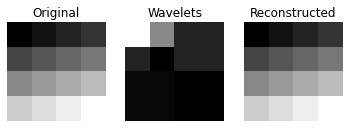

In [75]:
if __name__=='__main__':
    '''
    This program does wavelet analysis of an input image,
    and then reconstructs it back.
    User can modify following parameters:
    
    img=cv.imread('name of the image')   : to read other images
    atype   : 0 for tree wavelet , 1 for packet wavelet analysis
    level   : >0, levels of wavelet analysis is required
    '''
    img=np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]])
    atype=0          # 0 : tree wavelet analysis, 1: packet wavelet analysis
    level=2          # level upto which wavelet analysis to be done
 
    if atype==0:
        oimg=treeWaveletAnalysis(img,level)
    else:
        oimg=packetWaveletAnalysis(img,level)
    rimg=reconstruct(oimg,level,atype)
    
    showResults(img,oimg,rimg)